# Calculating GB energy from DF

## Objective

(i) Select data from boundaries
(ii) Organize it for all grains
(iii) Calculate the energy with wield

## Method

    * Open Dataframe
    * Select attributes of interest from boundaries
    * Create a new DF with grain information
    * Convert data to wield
    * Run wield for all grains
    * Store energy in Dataframe

In [3]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill

from matplotlib import pyplot as plt


### Open Dataframe


In [4]:

folder = "../data/"
file = "1_005"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [5]:
df.grain_right.drop_duplicates(keep = False)

10      1120.0
25      2455.0
35      3207.0
39      3372.0
44      3595.0
         ...  
7311    1901.0
7324    2874.0
7328    2486.0
7330    3008.0
7340     130.0
Name: grain_right, Length: 420, dtype: float64

### Select attributes of interest from boundaries

The group of information that is directly related to the grain: 
* Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
* Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
* Column 7:     Misorientation Angle
* Column 8-10:  Misorientation Axis in Right Hand grain
* Column 11-13: Misorientation Axis in Left Hand grain
* Column 20-21: IDs of right hand and left hand grains

The Columns 20-21 describe the grain of interest

The Columns 1-6 depends on grain itself, **here we are interested**

The Columns 7-13 depends on left and right grains

In [6]:
#df_left = df[['ori_angle','left_phi1','left_PHI','left_phi2','left_ori_x','left_ori_y','left_ori_z','grain_left']]
#df_right = df[['right_phi1','right_PHI','right_phi2','right_ori_x','right_ori_y','right_ori_z','grain_right']]

# left_ori is related with other grain, than is not interesting to keep in this case

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})


df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})


In [7]:
df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')


In [8]:
df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')


In [9]:
#df_grains = pd.concat([df_left,df_right])
df_grains = df_left.join(df_right)
df_grains_l = df_left.join(df_right)
df_grains_r = df_right.join(df_left)

In [10]:
df_grains_l.isnull().sum(),df_grains_r.isnull().sum()

(left_phi1      0
 left_PHI       0
 left_phi2      0
 right_phi1    67
 right_PHI     67
 right_phi2    67
 dtype: int64,
 right_phi1     0
 right_PHI      0
 right_phi2     0
 left_phi1     34
 left_PHI      34
 left_phi2     34
 dtype: int64)

In [11]:
df_grains.sort_values('grain')

,left_phi1,left_PHI,left_phi2,right_phi1,right_PHI,right_phi2
grain,,,,,,
1.0,2.108,0.507,4.677,NaN,NaN,NaN
2.0,3.569,0.749,2.910,3.569,0.749,2.910
3.0,1.016,0.709,4.944,1.016,0.709,4.944
4.0,2.562,0.698,3.682,2.562,0.698,3.682
5.0,5.593,0.898,0.472,5.593,0.898,0.472
...,...,...,...,...,...,...
4217.0,3.249,0.193,3.117,3.249,0.193,3.117
4219.0,1.612,0.626,4.360,NaN,NaN,NaN
4220.0,1.188,0.543,4.660,1.188,0.543,4.660


In [12]:
df_grains.isnull().sum()

left_phi1      0
left_PHI       0
left_phi2      0
right_phi1    67
right_PHI     67
right_phi2    67
dtype: int64

## Fill Grains based on phi1, PHI, and phi2

In [13]:
df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [23]:
grain = 1512

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
One_grain

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left
5766,3.095,0.064,3.177,4.203,0.598,1.343,53.25,1.0,18.0,22.0,...,18.0,22.0,6.000,120.0,1091.0,373.55,1094.0,378.74,1721.0,1512.0
5767,4.203,0.598,1.343,4.401,0.759,1.291,13.02,-14.0,11.0,-9.0,...,11.0,-9.0,18.000,60.0,1091.0,373.55,1100.0,357.96,1512.0,1537.0
5778,4.675,0.693,0.902,4.203,0.598,1.343,17.38,24.0,3.0,-5.0,...,3.0,-5.0,40.596,170.2,1094.0,378.74,1134.0,385.67,1791.0,1512.0
5779,4.675,0.693,0.902,4.203,0.598,1.343,17.38,24.0,3.0,-5.0,...,3.0,-5.0,15.144,22.4,1134.0,385.67,1148.0,379.90,1791.0,1512.0
5811,4.203,0.598,1.343,4.766,0.284,1.534,45.95,-6.0,-10.0,-21.0,...,-10.0,-21.0,10.392,30.0,1100.0,357.96,1109.0,352.76,1512.0,1240.0
5861,4.203,0.598,1.343,3.706,0.245,2.503,45.73,2.0,-11.0,-19.0,...,-11.0,-19.0,1.155,30.0,1109.0,352.76,1110.0,352.18,1512.0,1460.0
5909,4.203,0.598,1.343,4.345,0.671,1.232,6.37,-26.0,12.0,-1.0,...,12.0,-1.0,3.055,10.9,1122.0,354.49,1125.0,353.92,1512.0,1516.0
5941,4.179,0.805,2.434,4.203,0.598,1.343,30.92,-7.0,-3.0,-18.0,...,-3.0,-18.0,4.000,180.0,1129.0,353.92,1133.0,353.92,1519.0,1512.0
5973,3.728,0.134,2.642,4.203,0.598,1.343,49.73,11.0,10.0,-22.0,...,10.0,-22.0,4.000,180.0,1133.0,353.92,1137.0,353.92,1520.0,1512.0
6018,5.336,0.748,1.376,4.203,0.598,1.343,52.61,15.0,-14.0,-17.0,...,-14.0,-17.0,1.155,150.0,1139.0,353.92,1140.0,354.49,1496.0,1512.0


In [46]:
#del mask
grain_info = df_grains_norm.loc[grain,:]
grain_info

left_phi1     0.668896
left_PHI      0.573982
left_phi2     0.213660
right_phi1    0.668896
right_PHI     0.573982
right_phi2    0.213660
Name: 1512.0, dtype: float64

In [47]:

width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

width,height

(1149, 386)

In [48]:
x_center = 1000#int(One_grain[['x_start','x_end']].mean().mean())
y_center = 300#int(One_grain[['y_start','y_end']].mean().mean())

In [49]:
One_grain.y_start.iloc[1:3]

5767    373.55
5778    378.74
Name: y_start, dtype: float64

The method polygon_fill do not work because it uses the Even–odd rule and fill all closed paths based on directions provided as parameters. As the order or parameters meters and in our case is not ordered, this method is not helpful.


## Flood Fill method

In [50]:
One_grain.x_start

5766    1091.0
5767    1091.0
5778    1094.0
5779    1134.0
5811    1100.0
5861    1109.0
5909    1122.0
5941    1129.0
5973    1133.0
6018    1139.0
6021    1140.0
6053    1147.0
Name: x_start, dtype: float64

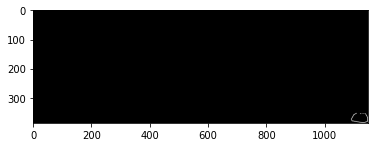

In [51]:

np_img = np.zeros([height, width, 3])
np_img2 = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])

plt.imshow(np_img)

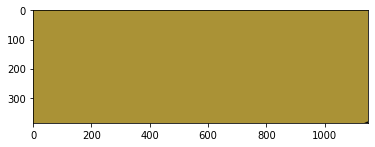

In [52]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
np_img2[mask[:,:,1]] = [phi1,Phi,phi2]
np_img2[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]


plt.imshow(np_img2)

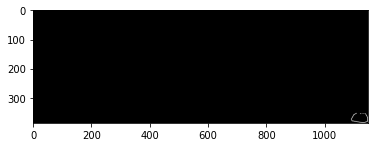

In [53]:
grain = 1512

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
grain_info = df_grains_norm.loc[grain,:]
x_center = int(One_grain[['x_start','x_end']].mean().mean())
y_center = int(One_grain[['y_start','y_end']].mean().mean())

np_img = np.zeros([height, width, 3])
#np_img2 = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
    #print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])

plt.imshow(np_img)

In [54]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
np_img2 += np_img

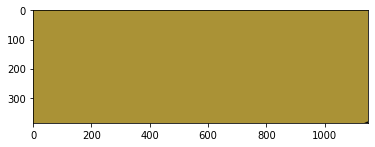

In [55]:
plt.imshow(np_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


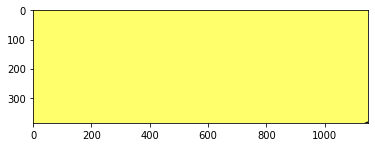

In [56]:
plt.imshow(np_img2)

Applying to all grains

In [57]:
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
import cv2
import time
import math



df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1

#for idx, row in df.iterrows():
#    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
#    np_img[cc,rr,:3] = (1,1,1)
    
#plt.imshow(np_img)


In [58]:
%%time

np_img = np.zeros([height, width, 3])
flood_grains = np.zeros([height, width, 3])


width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1
flood_grains = np.zeros([height, width, 3])
overflood = np.sum(flood_grains==0) * 0.8

for grain in df_grains.index:
    One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
    grain_info = df_grains_norm.loc[grain,:]
    np_img = np.zeros([height, width, 3])

  #  width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
  #  height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

    x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
    y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


    if(y_center < 2100 and y_center < 2400):    
        phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
        #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)
    
        for idx, row in One_grain.iterrows():
            
            rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
            np_img[cc,rr] = (1,1,1)
        
        mask = flood(np_img, (y_center, x_center,0))
#        print(str(grain) + " len "+ str(np.count_nonzero(mask)))
#        print(str(grain) + " len 0 "+ str(np.sum(mask==1)))
        np_img[np_img[:,:,1] !=0] =  [0,0,0]#[phi1,Phi,phi2]
        
#         cv2.imshow('NP',np_img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

        if (np.sum(mask==1)<overflood):
            np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            
        else:
            start = pd.DataFrame(columns=["x","y"])
            end = pd.DataFrame(columns=["x","y"])
            start[["x","y"]] = One_grain[['x_start','y_start']]
            end[["x","y"]] = One_grain[['x_end','y_end']]
            points = pd.concat([start,end])
            

            
            try :
                hull = ConvexHull(points)
                for idx in range(len(hull.simplices)):
                    x_s = hull.points[hull.simplices[idx,0], 0].astype("uint16")
                    y_s = hull.points[hull.simplices[idx,0], 1].astype("uint16")
                    x_e = hull.points[hull.simplices[idx,1], 0].astype("uint16")
                    y_e = hull.points[hull.simplices[idx,1], 1].astype("uint16")

                    rr,cc,a = draw.line_aa(x_s,y_s,x_e,y_e)
                    
                    np_img[cc,rr] = (1,1,1)
            except:
                print(points)
                pass
           
            
            mask = flood(np_img, (y_center, x_center,0))

            np_img[np_img[:,:,1] !=0] =  [0,0,0]
            np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
            
        flood_grains += np_img


        cv2.imshow('Image',flood_grains)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

plt.imshow(flood_grains)
io.imsave("processing/"+ file +'.png',np_img)

KeyboardInterrupt: 

In [59]:
cv2.imshow('F',flood_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [60]:
io.imsave("processing/"+ file +'.png',flood_grains)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [61]:
grain = 1512
One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]


width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1


grain_info = df_grains_norm.loc[grain,:]
np_img = np.zeros([height, width, 3])


x_center = math.floor(One_grain[['x_start','x_end']].mean().mean())
y_center = math.floor(One_grain[['y_start','y_end']].mean().mean())


if(x_center <2100 and y_center < 2100):    
    phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
    #    cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)

    start = pd.DataFrame(columns=["x","y"])
    end = pd.DataFrame(columns=["x","y"])
    start[["x","y"]] = One_grain[['x_start','y_start']]
    end[["x","y"]] = One_grain[['x_end','y_end']]
    points = pd.concat([start,end])
    points.reset_index()



    hull = ConvexHull(points)
    for idx in range(len(hull.simplices)):
        x_s = hull.points[hull.simplices[idx,0], 0].astype("uint16")
        y_s = hull.points[hull.simplices[idx,0], 1].astype("uint16")
        x_e = hull.points[hull.simplices[idx,1], 0].astype("uint16")
        y_e = hull.points[hull.simplices[idx,1], 1].astype("uint16")

        rr,cc,a = draw.line_aa(x_s,y_s,x_e,y_e)
        np_img[cc,rr] = (1,1,1)

    mask = flood(np_img, (y_center, x_center,0))
    
    np_img[np_img[:,:,1] !=0] =  [phi1,Phi,phi2]
    np_img[mask[:,:,1] !=0] = [phi1,Phi,phi2]
    
plt.imshow(np_img)
print(np.sum(mask==1))

NameError: name 'ConvexHull' is not defined

In [62]:
count(np_img==1)

NameError: name 'count' is not defined

In [63]:
cv2.imshow('f',flood_grains)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [64]:
io.imsave("processing/"+ file +'_partial.png',np_img)

/var/folders/cs/9snn7fmd4sz6wvcngh6vx9cm0000gp/T/ipykernel_14602/2232076594.py:1: UserWarning: processing/1_005_partial.png is a low contrast image
  io.imsave("processing/"+ file +'_partial.png',np_img)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Some grains are not in the df_grains dataframe.

In [65]:
df[df["grain_left"].isnull()]

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left


In [66]:
df["grain_left"].unique()

array([1.000e+00, 3.700e+01, 6.400e+01, ..., 4.076e+03, 3.712e+03,
       1.300e+02])

In [67]:
for a in df["grain_right"].unique():
    for b in df["grain_left"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_left"].unique()[-1]:
            print("right not found " + str(a))

right not found 593.0
right not found 4157.0
right not found 4198.0
right not found 598.0


KeyboardInterrupt: 

In [ ]:
for a in df["grain_left"].unique():
    for b in df["grain_right"].unique():
        if a == b:
          # print("right found " + str(a))
            break
        if b == df["grain_right"].unique()[-1]:
            print("left not found " + str(a))

## Closing opened grains

In [68]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
grain = 1512


One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]


grain_info = df_grains_norm.loc[grain,:]
np_img = np.zeros([height, width, 3])

start = pd.DataFrame(columns=["x","y"])
end = pd.DataFrame(columns=["x","y"])
start[["x","y"]] = One_grain[['x_start','y_start']]
end[["x","y"]] = One_grain[['x_end','y_end']]
points = pd.concat([start,end])
points.reset_index()

    


,index,x,y
0,5766,1091.0,373.55
1,5767,1091.0,373.55
2,5778,1094.0,378.74
3,5779,1134.0,385.67
4,5811,1100.0,357.96
5,5861,1109.0,352.76
6,5909,1122.0,354.49
7,5941,1129.0,353.92
8,5973,1133.0,353.92
9,6018,1139.0,353.92


In [69]:


width = int(max([max(df.x_end),max(One_grain.x_start)]))+1
height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1
np_img = np.zeros([height, width, 3])

hull = ConvexHull(points)
for idx in range(len(hull.simplices)):
    x_s = hull.points[hull.simplices[idx,0], 0].astype("uint16")
    y_s = hull.points[hull.simplices[idx,0], 1].astype("uint16")
    x_e = hull.points[hull.simplices[idx,1], 0].astype("uint16")
    y_e = hull.points[hull.simplices[idx,1], 1].astype("uint16")
    
    rr,cc,a = draw.line_aa(x_s,y_s,x_e,y_e)
    np_img[cc,rr] = (1,1,1)


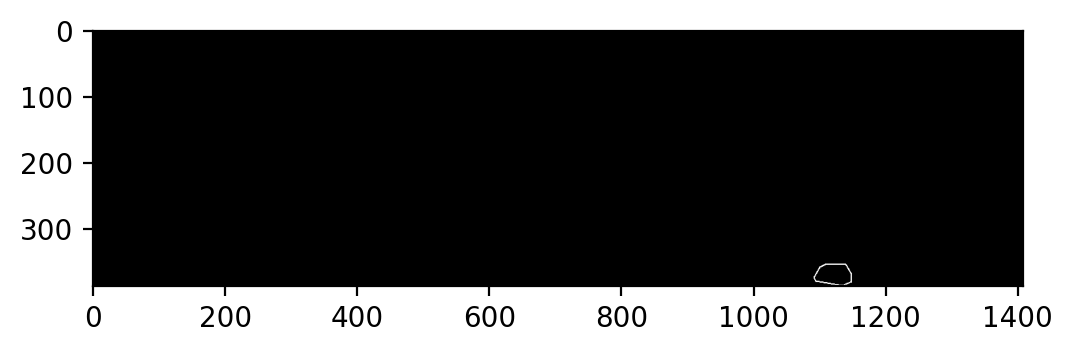

In [70]:
plt.imshow(np_img)

In [71]:
len(hull.simplices)

9

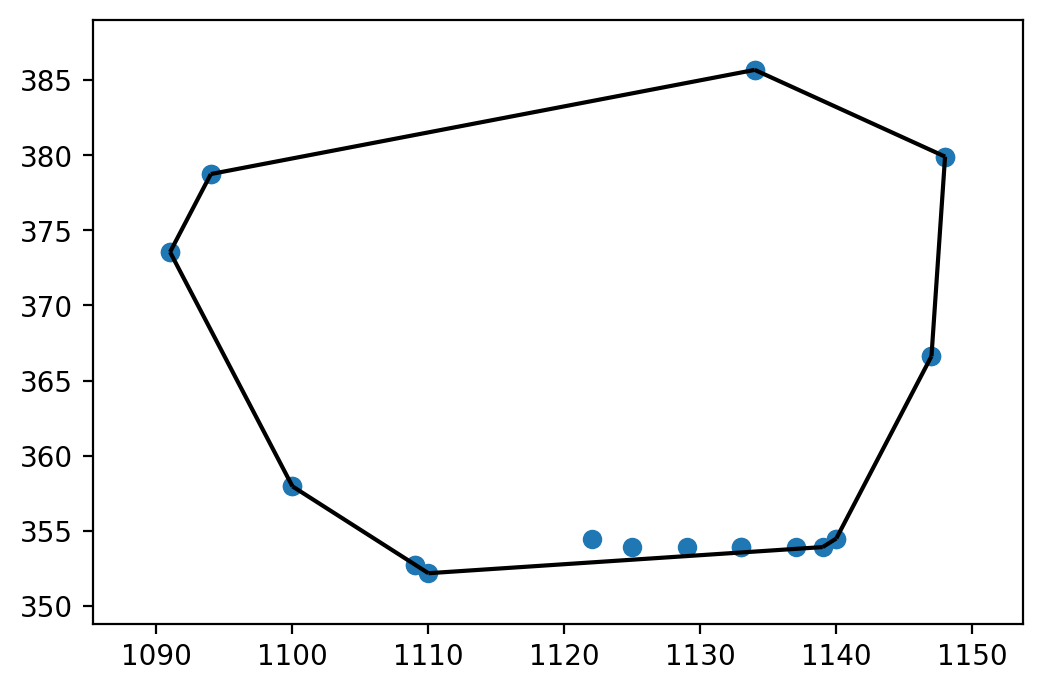

In [72]:
hull = ConvexHull(points)
a = convex_hull_plot_2d(hull)
plt.show()


In [ ]:
import cv2
np_img = np.zeros([50, 50, 3])
test = cv2.fillPoly(np_img, pts = [points.values.tolist()], color =(255,255,255))
plt.imshow(test)

In [ ]:
hull.points[hull.simplices[0,1], :] 